# Final Notebook

In [3]:
import pandas as pd
import numpy as np
import nltk
import sklearn
import string, re
import urllib
import seaborn as sbn
from sklearn.model_selection import train_test_split, GridSearchCV
from sklearn.preprocessing import OneHotEncoder,StandardScaler,LabelEncoder
from sklearn.feature_extraction.text import TfidfVectorizer
from sklearn.ensemble import RandomForestRegressor
from sklearn.decomposition import PCA
from nltk.corpus import stopwords

## Import Data Saved in Data Folder into a Pandas DataFrame

In [4]:
data = pd.read_csv('../../Data/2019/listings122019long.csv')

## Drop Columns That Are Not Needed

These columns consist of images, extra user descriptions of their properties, prices based on extended lengths of time and various other descriptors that are too specific to properties or that I just have not had enough time to go through at this point.

In [5]:
data1 = data.drop(columns=['listing_url','scrape_id','last_scraped','summary','space','description','experiences_offered',
                           'neighborhood_overview','notes','transit','access','interaction','house_rules',
                           'thumbnail_url','medium_url','picture_url','xl_picture_url','host_id','host_url',
                           'host_name','host_since', 'host_location','host_about','host_response_time','host_response_rate',
                           'host_acceptance_rate', 'host_thumbnail_url','host_picture_url', 'host_neighbourhood',
                           'host_listings_count','host_total_listings_count', 'host_verifications','host_has_profile_pic',
                           'host_identity_verified','street', 'city','state','zipcode','market','country_code',
                           'country', 'is_location_exact','bed_type','amenities','square_feet','weekly_price',
                           'monthly_price','security_deposit','guests_included','extra_people','maximum_nights',
                           'minimum_minimum_nights','maximum_minimum_nights', 'minimum_maximum_nights', 'maximum_maximum_nights',
                           'minimum_nights_avg_ntm', 'maximum_nights_avg_ntm', 'calendar_updated', 'has_availability',
                           'availability_30', 'availability_60', 'availability_90', 'availability_365', 'calendar_last_scraped','first_review',
                           'last_review','review_scores_accuracy', 'review_scores_cleanliness', 'review_scores_checkin',
                           'review_scores_communication', 'review_scores_location','requires_license', 'license',
                           'jurisdiction_names', 'instant_bookable', 'is_business_travel_ready', 'cancellation_policy',
                           'require_guest_profile_picture', 'require_guest_phone_verification', 'calculated_host_listings_count',
                           'calculated_host_listings_count_entire_homes', 'calculated_host_listings_count_private_rooms',
                           'calculated_host_listings_count_shared_rooms', 'neighbourhood','smart_location','id','property_type'
                          ])

## Change Price to Numerical and Get rid of NaNs in data

To use this data in a regression model I cannot have any columns that are not numbers.

In [6]:
data1['price'] = data1['price'].str.extract('(\d+)', expand=False).astype('float')

In [7]:
data1['cleaning_fee'] = data1['cleaning_fee'].str.extract('(\d+)', expand=False).astype('float')

In [8]:
data1['host_is_superhost'] = (data1['host_is_superhost'] == 't').astype('int')

In [9]:
data1['reviews_per_month'] = data1['reviews_per_month'].fillna(0)
data1['bathrooms'] = data1['bathrooms'].fillna(data1['bathrooms'].mean())
data1['bedrooms'] = data1['bedrooms'].fillna(data1['bedrooms'].mean())
data1['beds'] = data1['beds'].fillna(data1['beds'].mean())
data1['cleaning_fee'] = data1['cleaning_fee'].fillna(data1['cleaning_fee'].mean())
data1['review_scores_rating'] = data1['review_scores_rating'].fillna(0)

In [10]:
data1['longitude'] = data1['longitude'].round(decimals=5)
data1['latitude'] = data1['latitude'].round(decimals=5)

In [11]:
data1 = data1[data1.minimum_nights<31]

# Vectorize Categorical Variables

For descriptive features that are repetitive I used OneHotEncoding to create their own DataFrames that let me know if the descriptor was used in a row or not.

In [12]:
ohe = OneHotEncoder(sparse=False)
neigh_group = ohe.fit_transform(data1[['neighbourhood_group_cleansed']])
neigh_group_cat = ohe.categories_
neigh = ohe.fit_transform(data1[['neighbourhood_cleansed']])
neigh_cat = ohe.categories_
room = ohe.fit_transform(data1[['room_type']])
room_cat = ohe.categories_
minimum = ohe.fit_transform(data1[['minimum_nights']])
minimum_cat = ohe.categories_

In [13]:
minimum_cat = minimum_cat[0].astype('str')

In [14]:
minimum_cat = list(minimum_cat)

In [15]:
new_minimum_cat = [(lambda x : f'minimum_nights: {x}')(x) for x in range(len(minimum_cat))]

In [16]:
def rename(name_of_columns,pre_addition):
    new_list = []
    for x in name_of_columns:
        for x in x:
            new_list.append(pre_addition+ '' + x)
    return new_list

In [17]:
new_neigh_group_cat = rename(neigh_group_cat,'neighbourhood_group: ')
new_neigh_cat = rename(neigh_cat,'neighbourhood: ')
new_room_cat = rename(room_cat,'room_type: ')

In [18]:
# Create categories for neighborhood_group, neighborhood and room_type
neigh_group_df = pd.DataFrame(data=neigh_group,columns=new_neigh_group_cat)
neigh_df = pd.DataFrame(data=neigh,columns=new_neigh_cat)
room_type_df = pd.DataFrame(data=room,columns = new_room_cat)
minimum_df = pd.DataFrame(data=minimum,columns=new_minimum_cat)

# NLP for Name Category

For the 'name' feature I used a Natural Language Processing to Vectorize key words that people included both individually and in groups.

In [19]:
stopwords_list = stopwords.words('english') + list(string.punctuation)
vectorizer = TfidfVectorizer(strip_accents='unicode',stop_words=stopwords_list,min_df=60,max_df = 800, ngram_range=(1,3))
# get rid of na in name column
data1.fillna({'name':''}, inplace=True)
tf_idf = vectorizer.fit_transform(data['name'])
nlp_name = pd.DataFrame(tf_idf.toarray(), columns=vectorizer.get_feature_names())

# Reconnect DataFrames / Drop Duplicates

In [20]:
clean_data = pd.concat([data1,neigh_group_df,neigh_df,room_type_df,nlp_name,minimum_df],axis=1)

In [21]:
clean_data = clean_data.drop(columns=['name','neighbourhood_cleansed','minimum_nights',
                                      'neighbourhood_group_cleansed','room_type'])

# Remove New/ Unsuccessful Properties

Since the purpose of this project was to get a prediction of someones property that would be successful, I removed properties that had a review score rating below 60 out of 100.

In [22]:
clean_data = clean_data[clean_data.review_scores_rating>60]

I then had to remove some properties that were drastic outlier with prices of 0 or 9999/per night. I am not sure if these were input errors or if the website/ user had them for rediculous prices to avoid changing availibility.

In [23]:
clean_data = clean_data[clean_data.price>20]
clean_data = clean_data[clean_data.price<800]
clean_data = clean_data.dropna()

# Visualize Data

In [24]:
import seaborn as sbn
import statsmodels
import statsmodels.api as sm
import matplotlib.pyplot as plt
import scipy.stats as stats

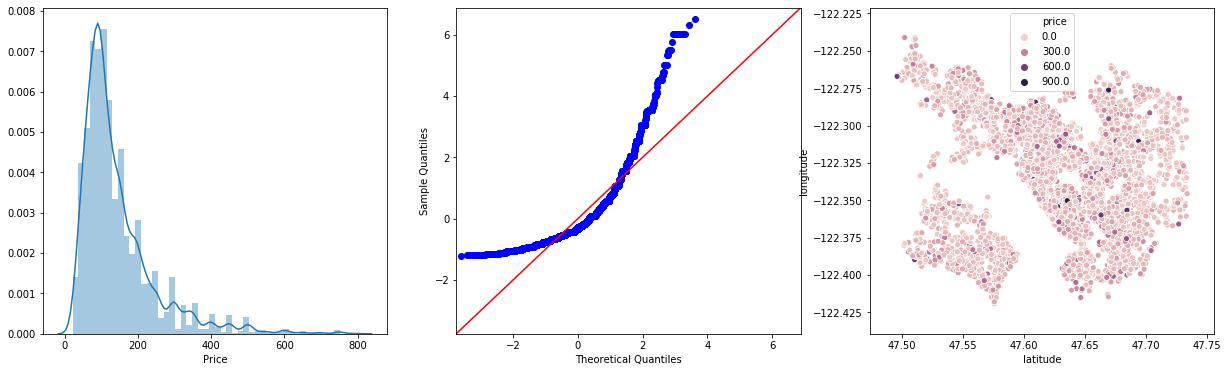

In [25]:
fig, axes = plt.subplots(1,3, figsize=(21,6))
sbn.distplot(clean_data['price'], ax=axes[0])
axes[0].set_xlabel('Price')
sm.qqplot(np.log1p(clean_data['price']), stats.norm, fit=True, line='45', ax=axes[1])
sbn.scatterplot(x= clean_data['latitude'], y=clean_data['longitude'],hue=clean_data['price'],ax=axes[2]);

# Train Test Split

In [36]:
ss = StandardScaler()
X = clean_data.drop(columns=['price','number_of_reviews_ltm','review_scores_rating',
                             'review_scores_value','reviews_per_month'])
Xss = ss.fit_transform(X)
y = clean_data['price']
Xtrain,Xtest,ytrain,ytest = train_test_split(Xss,y,test_size = .05,random_state=11)

# Random Forest

In [37]:
rfr = RandomForestRegressor(n_estimators=400,min_samples_split=5,min_samples_leaf=3,random_state=11)
rfr.fit(Xtrain,ytrain)
rfr.score(Xtrain,ytrain)

0.8829890440246375

In [38]:
ypredtrain = rfr.predict(Xtrain)
ypredtest = rfr.predict(Xtest)

In [39]:
from sklearn.metrics import r2_score, explained_variance_score,mean_absolute_error,mean_squared_error
print(r2_score(ytrain,ypredtrain))
print(r2_score(ytest,ypredtest))

0.8829890440246375
0.6702862849311708


In [42]:
sorted(list(zip(rfr.feature_importances_,X.columns)),reverse=True)[0:10]

[(0.35144037222536934, 'bedrooms'),
 (0.15947828725352325, 'cleaning_fee'),
 (0.07524200465507984, 'latitude'),
 (0.05502474742580563, 'bathrooms'),
 (0.05106904582674603, 'accommodates'),
 (0.046951777897031345, 'longitude'),
 (0.03591560402042651, 'number_of_reviews'),
 (0.01753515915313084, 'suites'),
 (0.011159456188863819, 'beds'),
 (0.009359603723938431, 'views')]

In [41]:
list(zip(ytest,ypredtest))[0:10]

[(80.0, 105.54691378066379),
 (224.0, 166.57036823593072),
 (85.0, 67.81734956709957),
 (169.0, 171.9980995670996),
 (85.0, 84.55059559884559),
 (95.0, 82.6176356906982),
 (299.0, 217.60385203440367),
 (125.0, 203.17849377011873),
 (99.0, 93.93652862415352),
 (85.0, 90.01855639499392)]

# Neural Net

In [31]:
from tensorflow.python.keras.models import Sequential
from tensorflow.python.keras.layers import Dense
from tensorflow.python.keras.layers import Dropout
from tensorflow.python.keras.wrappers.scikit_learn import KerasRegressor
from sklearn.model_selection import KFold

In [65]:
model = Sequential()
model.add(Dense(len(X.columns), input_dim=len(X.columns), kernel_initializer='normal', activation='relu'))
model.add(Dense(200,activation='relu'))
model.add(Dense(100,activation='relu'))
model.add(Dense(20,activation='relu'))
model.add(Dense(1, activation='linear'))
model.summary()

Model: "sequential_2"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
dense_6 (Dense)              (None, 308)               95172     
_________________________________________________________________
dense_7 (Dense)              (None, 200)               61800     
_________________________________________________________________
dense_8 (Dense)              (None, 100)               20100     
_________________________________________________________________
dense_9 (Dense)              (None, 20)                2020      
_________________________________________________________________
dense_10 (Dense)             (None, 1)                 21        
Total params: 179,113
Trainable params: 179,113
Non-trainable params: 0
_________________________________________________________________


In [66]:
model.compile(loss='mse', optimizer='adam', metrics=['mse','mae'])

In [67]:
history = model.fit(Xtrain, ytrain, epochs=100, batch_size=3,  verbose=0, validation_split=0.2)

In [68]:
nnpreds = []
for x in model.predict(Xtest):
    for x in x:
        nnpreds.append(x)

In [69]:
abs(sum(ytest)-sum(nnpreds))/len(ytest)

7.768100327711839

In [70]:
print(explained_variance_score(ytest,ypredtest))
print(explained_variance_score(ytest,nnpreds))

0.6670197026227429
0.5236416850711281


In [71]:
print(mean_absolute_error(ytest,ypredtest))
print(mean_absolute_error(ytest,nnpreds))

33.80013775637232
41.40839881310096


In [72]:
print(r2_score(ytest,ypredtest))
print(r2_score(ytest,nnpreds))

0.6668047457943016
0.5171472662731584


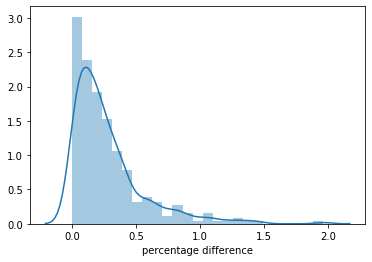

In [58]:
sbn.distplot(list(abs(ytest-ypredtest)/ytest),axlabel='percentage difference');

In [74]:
sum(abs(ytest-ypredtest)/ytest)/len(ytest)

0.27771830332693

In [41]:
list(abs(ytest-ypredtest)/ytest)[:10]

[0.3140896586052856,
 0.24357112192123317,
 0.19026620523267535,
 0.014021962012346923,
 0.00041639990728249227,
 0.1257278444070549,
 0.2739389389350238,
 0.636304238139637,
 0.0535138636764296,
 0.05234624943683741]

In [42]:
sum(abs(ytest-nnpreds)/ytest)/len(ytest)

0.33681516253933436

In [43]:
list(zip(abs(ytest-nnpreds),abs(ytest-ypredtest)))[:10]

[(18.47435760498047, 25.127172688422846),
 (37.55180358886719, 54.559931310356234),
 (7.056434631347656, 16.172627444777405),
 (0.16009521484375, 2.36971158008663),
 (8.906455993652344, 0.03539399211901184),
 (33.48249053955078, 11.944145218670215),
 (213.57007598876953, 81.90774274157212),
 (29.62762451171875, 79.53802976745462),
 (25.05511474609375, 5.297872503966531),
 (36.13814163208008, 4.44943120213118)]

In [47]:
list(zip(nnpreds,ytest,ypredtest))[:10]

[(61.525642, 80.0, 105.12717268842285),
 (186.4482, 224.0, 169.44006868964377),
 (77.943565, 85.0, 68.8273725552226),
 (169.1601, 169.0, 171.36971158008663),
 (93.906456, 85.0, 84.96460600788099),
 (61.51751, 95.0, 83.05585478132978),
 (85.429924, 299.0, 217.09225725842788),
 (154.62762, 125.0, 204.53802976745462),
 (73.944885, 99.0, 93.70212749603347),
 (48.86186, 85.0, 89.44943120213118)]